### Load the required libraries and functions 

In [1]:
import warnings
import pickle
import math
import xgboost
import re
import graphviz
import joblib
import random
import sys
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import tree
from scipy import stats
from scipy.stats import ks_2samp
from datetime import timedelta

project_path = '/Users/naresh/Downloads/DS/growth/nsl_v2/nsl_v2_final/'
sys.path.insert(0, project_path+'config')
from config import SQLQuery

random.seed(3)
sns.set_theme(style="ticks", color_codes=True)
# Avoid warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

/Users/naresh/.pyenv/versions/3.9.2/envs/nsl_v2/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df_split_data = pd.read_pickle(project_path+'data/nsl_train_test_flag_2023-05-30.pkl')
df = pd.read_pickle(project_path+'data/nsl_raw_dataset_2023-05-30.pkl')

In [3]:
df = pd.merge(df,df_split_data[['application_id','train_flag','test_flag']], on='application_id', how='inner')
df = df[df.train_flag==1].reset_index(drop=True)

### Alloy Features 

In [4]:
alloy_cols = ['application_id', 'created_datetime', 'entity', 'entity_id',
       'application_version_id', 'person_outcome', 'person_outcome_reasons',
       'person_result', 'person_score', 'person_tags', 'ida', 'iovation',
       'lexis_nexus', 'sentilink', 'socure', 'white_pages_pro', 'qualifile',
       'ida_score', 'ida_score_reason_1', 'ida_score_reason_2',
       'ida_score_reason_3', 'iovation_device_type',
       'iovation_device_timezone', 'iovation_device_ip',
       'iovation_device_ip_isp', 'iovation_device_ip_city',
       'iovation_device_ip_country_code', 'iovation_device_ip_region',
       'iovation_device_ip_org', 'iovation_proxy_in_use',
       'iovation_timezone_geolocation_mismatch', 'sentilink_abuse_score',
       'sentilink_first_party_synthetic_score',
       'sentilink_third_party_synthetic_score', 'sentilink_id_theft_score',
       'socure_sigma', 'socure_reason_code', 'socure_emailrisk',
       'socure_emailrisk_reason_code', 'socure_phonerisk',
       'socure_phonerisk_reason_code', 'socure_addressrisk',
       'socure_addressrisk_reason_code', 'carrier', 'line_type',
       'is_prepaid_phone','ns_flag']

In [5]:
# These features are not relevant to predict the target
drop_cols = ['created_datetime','entity','entity_id','application_version_id','person_outcome'
             ,'person_outcome_reasons','person_result','person_tags','iovation','lexis_nexus','sentilink','socure'
            ,'white_pages_pro','qualifile','iovation_device_ip','ida']

cols = list(filter(lambda i: i not in drop_cols, alloy_cols))
df = df[cols]

In [6]:
# Removing the features with fill rate less than 80%
more_nulls_cols = ['sentilink_id_theft_score','is_prepaid_phone']
cols = list(filter(lambda i: i not in more_nulls_cols, df.columns.to_list()))
df = df[cols]

In [7]:
# Removing quasi static features with contstat value greater than 98%
quasi_cols = ['iovation_proxy_in_use','iovation_timezone_geolocation_mismatch','iovation_device_ip_country_code']

cols = list(filter(lambda i: i not in quasi_cols, df.columns.to_list()))
df = df[cols]

In [8]:
num_cols = ['socure_emailrisk', 'socure_phonerisk', 'socure_addressrisk','socure_sigma','sentilink_abuse_score'
            ,'sentilink_first_party_synthetic_score','sentilink_third_party_synthetic_score','person_score'
            ,'ida_score']

cat_columns = ['iovation_device_type','iovation_device_timezone','iovation_device_ip_isp','iovation_device_ip_city'
               ,'iovation_device_ip_region','iovation_device_ip_org'
               ,'carrier','line_type']

# Reason codes - IDA
ida_reason_cols = ['ida_score_reason_1','ida_score_reason_2','ida_score_reason_3']

# Reason codes - Socure
socure_reason_cols = ['socure_reason_code','socure_emailrisk_reason_code','socure_phonerisk_reason_code'
                      ,'socure_addressrisk_reason_code']


#### Convert all types of nulls to one null representation

In [9]:
for col in df.columns:
    idx = df.index[df[col].isnull()].tolist()
    idx.extend(df.index[df[col].isna()].tolist())
    idx.extend(df.index[df[col] == ''].tolist())
    idx.extend(df.index[df[col] == '[]'].tolist())
    idx = list(set(idx))
    df.loc[idx, col] = None

#### Impute Values

In [10]:
# Numerical
df_impute = df[num_cols].median()
df_impute = pd.DataFrame(df_impute, columns=['impute_value']).reset_index().rename(columns={'index':'feature'})

# Categorical
df_tmp = df[cat_columns + ida_reason_cols + socure_reason_cols].mode().T
df_tmp = df_tmp.reset_index().rename(columns={'index':'feature', 0:'impute_value'})

df_impute = pd.concat([df_impute,df_tmp], axis=0)
df_impute.reset_index(drop=True, inplace=True)

df_impute.to_pickle(project_path+'models/df_impute.pkl') # Save the impute values as df

#### Imputing

In [11]:
# Fillna with median values because these features are skewed
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fillna with mode values because these features are skewed
for col in cat_columns:
    df[col] = df[col].fillna(df[col].mode()[0])

for col in ida_reason_cols:
    df[col] = df[col].fillna(df[col].mode()[0])
    
for col in socure_reason_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

#### Basic Stats

In [12]:
cols = df.drop(columns=['ns_flag']).columns.to_list()

df_stats = pd.DataFrame(columns = ['column','values','values_count_incna','values_count_nona','num_miss', 'pct_miss'])
tmp = pd.DataFrame()

for c in cols:
    tmp['column'] = [c]
    tmp['values'] = [df[c].unique()]
    tmp['values_count_incna'] = len(list(df[c].unique()))
    tmp['values_count_nona'] = int(df[c].nunique())
    tmp['num_miss'] = df[c].isnull().sum()
    tmp['pct_miss'] = (df[c].isnull().sum()/ len(df)).round(3)*100
    df_stats = df_stats.append(tmp)

In [13]:
df_stats.reset_index(drop=True, inplace=True)
df_stats

,column,values,values_count_incna,values_count_nona,num_miss,pct_miss
0,application_id,"[57bb2e5c-a4ae-4d25-a499-3c1ef4f53014, 31ba99c...",87292,87292,0,0.0
1,person_score,"[0.87, 0.7, 0.76, 0.83, 1.0, 0.88, 0.62, 0.91,...",86,86,0,0.0
2,ida_score,"[531.0, 552.0, 663.0, 535.0, 647.0, 584.0, 483...",649,649,0,0.0
3,ida_score_reason_1,"[992.0, 675.0, 233.0, 641.0, 628.0, 594.0, 153...",43,43,0,0.0
4,ida_score_reason_2,"[909.0, 627.0, 992.0, 594.0, 946.0, 675.0, 593...",48,48,0,0.0
5,ida_score_reason_3,"[963.0, 946.0, 992.0, 994.0, 909.0, 594.0, 675...",52,52,0,0.0
6,iovation_device_type,"[WINDOWS, CHROMEOS, IPHONE, MAC, ANDROID, IPAD...",11,11,0,0.0
7,iovation_device_timezone,"[360, 300, 420, 480, -540, 0, 240, 600, -420, ...",25,25,0,0.0
8,iovation_device_ip_isp,"[COMCAST, MCI COMMUNICATIONS SERVICES INC. D/...",2150,2150,0,0.0
9,iovation_device_ip_city,"[SPRING, WALDORF, READING, CHICAGO, ASHEVILLE,...",6489,6489,0,0.0


#### Numerical Features

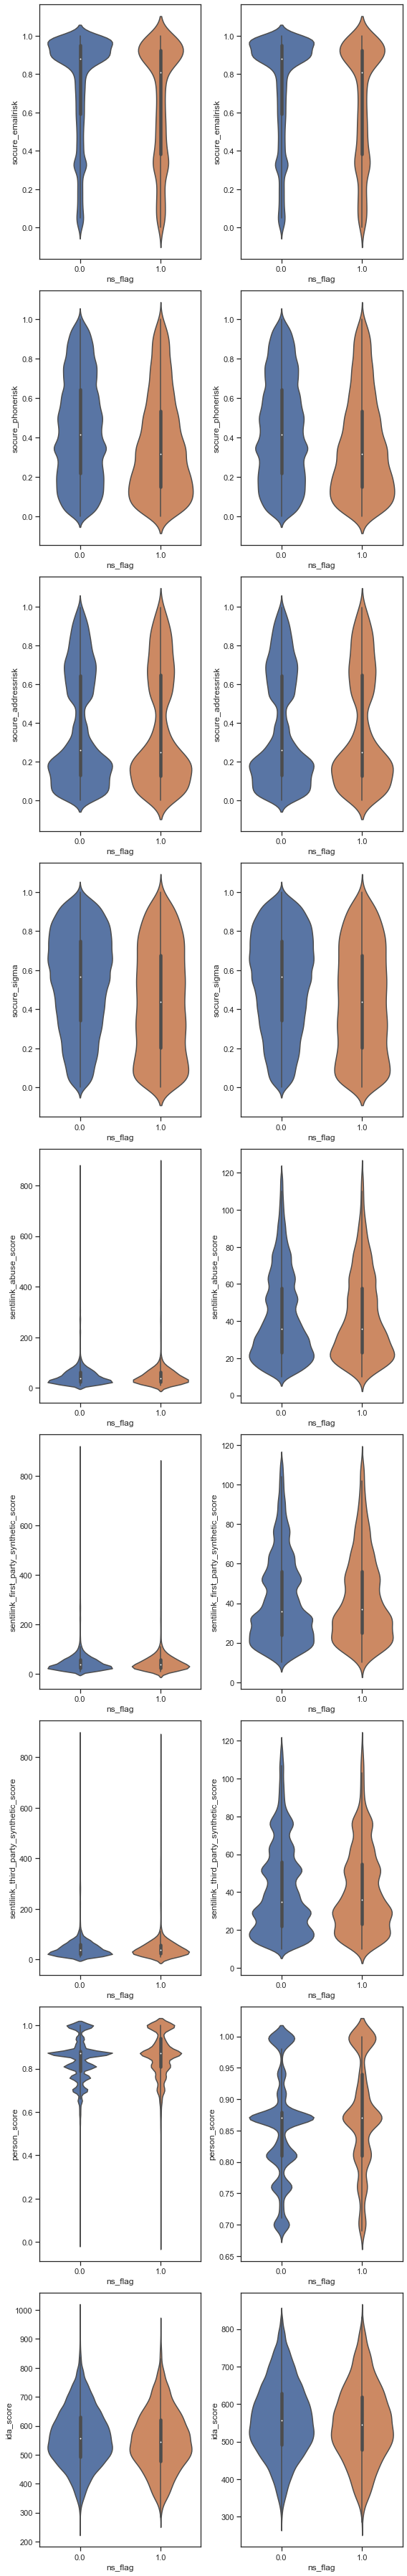

In [14]:
hue_col = 'ns_flag'

f, axes = plt.subplots(len(num_cols),2, figsize=(8, 50), sharex=False)
for i, col in enumerate(num_cols):
    sns.violinplot(y=col, x=hue_col, orient='v', data=df, ax=axes[i,0])
    
    # Capping upper and lower limits using IQR whiskers
    upper_limit = float(df[col].quantile([0.75]).values + 1.5*(df[col].quantile([0.75]).values - df[col].quantile([0.25]).values))
    lower_limit = float(df[col].quantile([0.25]).values - 1.5*(df[col].quantile([0.75]).values - df[col].quantile([0.25]).values))
    df_tmp = df[(df[col]<=upper_limit) & (df[col]>=lower_limit)].reset_index(drop=True)
    
    sns.violinplot(y=col, x=hue_col, orient='v', data=df_tmp, ax=axes[i,1])
    
plt.tight_layout()


#### Observations:

- None of these continuous features explain the best separation of the ns & regular customers
- All the socure score features are skewed
- ida score shows bell curve distribution 
- The extreme values are not outliers. So, not capping the values

### Correlation - Continuous Features

In [15]:
# Continuous data type features correlation
df[num_cols].corr()

,socure_emailrisk,socure_phonerisk,socure_addressrisk,socure_sigma,sentilink_abuse_score,sentilink_first_party_synthetic_score,sentilink_third_party_synthetic_score,person_score,ida_score
socure_emailrisk,1.000000,0.004373,-0.019378,0.393268,0.031657,0.025347,0.047160,-0.376508,0.315692
socure_phonerisk,0.004373,1.000000,0.150120,0.458204,0.112762,0.095954,0.099633,-0.331723,0.280849
socure_addressrisk,-0.019378,0.150120,1.000000,0.233016,0.039050,0.026900,0.042025,-0.148380,0.186688
socure_sigma,0.393268,0.458204,0.233016,1.000000,0.074525,0.067540,0.065264,-0.329942,0.380393
sentilink_abuse_score,0.031657,0.112762,0.039050,0.074525,1.000000,0.697672,0.672369,-0.171197,0.095804
sentilink_first_party_synthetic_score,0.025347,0.095954,0.026900,0.067540,0.697672,1.000000,0.458081,-0.149467,0.090435
sentilink_third_party_synthetic_score,0.047160,0.099633,0.042025,0.065264,0.672369,0.458081,1.000000,-0.191671,0.054322
person_score,-0.376508,-0.331723,-0.148380,-0.329942,-0.171197,-0.149467,-0.191671,1.000000,-0.306330
ida_score,0.315692,0.280849,0.186688,0.380393,0.095804,0.090435,0.054322,-0.306330,1.000000


### Categorical Features

#### iovation_device_type

In [16]:
col = 'iovation_device_type'
df[col] = df[col].str.lower()
idx_windows = df.index[df[col]=='windows'].tolist() 
idx_iphone = df.index[df[col]=='iphone'].tolist()
idx_mac = df.index[df[col]=='mac'].tolist() 
idx_android = df.index[df[col]=='android'].tolist()

# nulls
idx_nulls = df.index[df[col].isnull()].tolist()
idx_nulls.extend(df.index[df[col].isna()].tolist())
idx_nulls.extend(df.index[df[col]==''].tolist())
idx_nulls = list(set(idx_nulls))
idx_full = df.index.to_list()

# other
idx_other = list(set(idx_full) - set(idx_windows + idx_iphone + idx_mac + idx_android) - set(idx_nulls))

# Encode the categories
df.loc[idx_windows, col] = 'windows'
df.loc[idx_iphone, col] = 'iphone'
df.loc[idx_mac, col] = 'mac'
df.loc[idx_android, col] = 'android'
df.loc[idx_other, col] = 'other'

#### line_type

In [17]:
col = 'line_type'
df[col] = df[col].str.lower()
idx_mobile = df.index[df[col]=='mobile'].tolist() 

# nulls
idx_nulls = df.index[df[col].isnull()].tolist()
idx_nulls.extend(df.index[df[col].isna()].tolist())
idx_nulls.extend(df.index[df[col]==''].tolist())
idx_nulls = list(set(idx_nulls))
idx_full = df.index.to_list()

# other
idx_other = list(set(idx_full) - set(idx_mobile) - set(idx_nulls))

# Encode the categories
df.loc[idx_mobile, col] = 'mobile'
df.loc[idx_other, col] = 'other'

#### Analysing High Cardinality Features

Features with greater than 20 categories

#### iovation_device_timezone

In [18]:
col = 'iovation_device_timezone'
df[col] = df[col].str.lower()
idx_1 = df.index[df[col].isin(['300','360','480'])].tolist() 
# nulls
idx_nulls = df.index[df[col].isnull()].tolist()
idx_nulls.extend(df.index[df[col].isna()].tolist())
idx_nulls.extend(df.index[df[col]==''].tolist())
idx_nulls = list(set(idx_nulls))
idx_full = df.index.to_list()
# other
idx_other = list(set(idx_full) - set(idx_1) - set(idx_nulls))

# Encoding the categories
df.loc[idx_other, col] = 'other'

#### iovation_device_ip_isp

In [19]:
col = 'iovation_device_ip_isp'
df[col] = df[col].str.lower()
idx_verizon = df.index[df[col].str.contains('verizon')==True].tolist() 
idx_att = df.index[df[col].str.contains('at&t')==True].tolist() 

idx_att.extend(df.index[df[col].str.match('att')==True].tolist())
idx_att = list(set(idx_att))
idx_charter = df.index[df[col].str.match('charter [b|c]')==True].tolist() 
idx_comcast = df.index[df[col].str.match('comcast')==True].tolist() 


# nulls
idx_nulls = df.index[df[col].isnull()].tolist()
idx_nulls.extend(df.index[df[col].isna()].tolist())
idx_nulls.extend(df.index[df[col]==''].tolist())
idx_nulls = list(set(idx_nulls))
idx_full = df.index.to_list()

idx_other = list(set(idx_full) - set(idx_att + idx_charter + idx_verizon + idx_comcast) - set(idx_nulls))


In [20]:
df.loc[idx_att, col] = 'at&t'
df.loc[idx_charter, col] = 'charter'
df.loc[idx_verizon, col] = 'verizon'
df.loc[idx_comcast, col] = 'comcast'
df.loc[idx_other, col] = 'other'

#### iovation_device_ip_org

In [21]:
col = 'iovation_device_ip_org'
df[col] = df[col].str.lower()
# idx_tmobile = df.index[df[col].str.contains('t-mobile')==True].tolist() 
idx_verizon = df.index[df[col].str.contains('verizon')==True].tolist() 
idx_att = df.index[df[col].str.contains('at&t')==True].tolist() 

idx_att.extend(df.index[df[col].str.match('att')==True].tolist())
idx_att = list(set(idx_att))
idx_charter = df.index[df[col].str.match('charter [b|c]')==True].tolist() 
idx_comcast = df.index[df[col].str.match('comcast')==True].tolist() 
# idx_cox = df.index[df[col].str.match('cox c')==True].tolist()


# nulls
idx_nulls = df.index[df[col].isnull()].tolist()
idx_nulls.extend(df.index[df[col].isna()].tolist())
idx_nulls.extend(df.index[df[col]==''].tolist())
idx_nulls = list(set(idx_nulls))
idx_full = df.index.to_list()

idx_other = list(set(idx_full) - set(idx_att + idx_charter + idx_verizon + idx_comcast) - set(idx_nulls))

In [22]:
df.loc[idx_att, col] = 'at&t'
df.loc[idx_charter, col] = 'charter'
df.loc[idx_verizon, col] = 'verizon'
df.loc[idx_comcast, col] = 'comcast'
df.loc[idx_other, col] = 'other'

#### carrier

In [23]:
col = 'carrier'
df[col] = df[col].str.lower()
idx_tmobile = df.index[df[col].str.contains('t-mobile*')==True].tolist() 
idx_verizon = df.index[df[col].str.contains('verizon')==True].tolist() 
idx_att = df.index[df[col].str.contains('at&t')==True].tolist() 

idx_att.extend(df.index[df[col].str.match('att')==True].tolist())
idx_att = list(set(idx_att))


# nulls
idx_nulls = df.index[df[col].isnull()].tolist()
idx_nulls.extend(df.index[df[col].isna()].tolist())
idx_nulls.extend(df.index[df[col]==''].tolist())
idx_nulls = list(set(idx_nulls))
idx_full = df.index.to_list()
# other
idx_other = list(set(idx_full) - set(idx_att + idx_tmobile + idx_verizon) - set(idx_nulls))

In [24]:
df.loc[idx_att, col] = 'at&t'
df.loc[idx_tmobile, col] = 't-mobile'
df.loc[idx_verizon, col] = 'verizon'
df.loc[idx_other, col] = 'other'

#### iovation_device_ip_region

In [25]:
col = 'iovation_device_ip_region'
df[col] = df[col].str.lower()
tmp1 = pd.DataFrame(df[col].value_counts()).reset_index().rename(columns={col:'volume'})
tmp2 = pd.DataFrame(df.groupby([col]).ns_flag.mean()).reset_index().rename(columns={'ns_flag':'target_rate'})

tmp = pd.merge(tmp1, tmp2, left_on='index',right_on=col, how='inner')

tmp['vol_percent'] = tmp['volume'] * 100/df.shape[0]
tmp['target'] = np.round(tmp['volume'] * tmp['target_rate'] , 0)
tmp = tmp[[col]+['volume','vol_percent','target_rate','target']].sort_values(by=['vol_percent'], ascending=False)

In [26]:
high_ns_values = tmp[(tmp.volume>500) & (tmp.target_rate>=df.ns_flag.mean())][col].to_list()
low_ns_values = tmp[(tmp.volume>500) & (tmp.target_rate<df.ns_flag.mean())][col].to_list()

# df[col] = df[col].str.lower()
# idx_1 = df.index[df[col].isin(high_ns_values)].tolist() 
# idx_2 = df.index[df[col].isin(low_ns_values)].tolist() 

# # nulls
# idx_nulls = df.index[df[col].isnull()].tolist()
# idx_nulls.extend(df.index[df[col].isna()].tolist())
# idx_nulls.extend(df.index[df[col]==''].tolist())
# idx_nulls = list(set(idx_nulls))
# idx_full = df.index.to_list()
# # other
# idx_other = list(set(idx_full) - set(idx_1+idx_2) - set(idx_nulls))

# # Encoding into categories
# df.loc[idx_1, col] = 'high_ns'
# df.loc[idx_2, col] = 'low_ns'
# df.loc[idx_other, col] = 'other'

In [27]:
tmp[tmp[col].isin(high_ns_values)]

,iovation_device_ip_region,volume,vol_percent,target_rate,target
0,california,10141,11.617330,0.118627,1203.0
1,texas,8745,10.018100,0.087479,765.0
4,new york,4953,5.674059,0.112053,555.0
10,new jersey,2225,2.548916,0.095281,212.0
11,maryland,2164,2.479036,0.091035,197.0
13,arizona,1901,2.177748,0.095739,182.0
14,colorado,1846,2.114741,0.100217,185.0
17,washington,1468,1.681712,0.108992,160.0
21,nevada,1075,1.231499,0.093953,101.0
22,massachusetts,1070,1.225771,0.123364,132.0


In [28]:
pd.DataFrame(high_ns_values, columns=[col]).to_pickle(project_path+'models/high_ns_region.pkl')
pd.DataFrame(low_ns_values, columns=[col]).to_pickle(project_path+'models/low_ns_region.pkl')

#### iovation_device_ip_city

In [29]:
col = 'iovation_device_ip_city'
df[col] = df[col].str.lower()
tmp1 = pd.DataFrame(df[col].value_counts()).reset_index().rename(columns={col:'volume'})
tmp2 = pd.DataFrame(df.groupby([col]).ns_flag.mean()).reset_index().rename(columns={'ns_flag':'target_rate'})

tmp = pd.merge(tmp1, tmp2, left_on='index',right_on=col, how='inner')

tmp['vol_percent'] = tmp['volume'] * 100/df.shape[0]
tmp['target'] = np.round(tmp['volume'] * tmp['target_rate'] , 0)
tmp = tmp[[col]+['volume','vol_percent','target_rate','target']].sort_values(by=['vol_percent'], ascending=False)

In [30]:
col = 'iovation_device_ip_city'
high_ns_values = tmp[(tmp.volume>500) & (tmp.target_rate>=df.ns_flag.mean())][col].to_list()
low_ns_values = tmp[(tmp.volume>500) & (tmp.target_rate<df.ns_flag.mean())][col].to_list()

df[col] = df[col].str.lower()
idx_1 = df.index[df[col].isin(high_ns_values)].tolist() 
idx_2 = df.index[df[col].isin(low_ns_values)].tolist() 

# nulls
idx_nulls = df.index[df[col].isnull()].tolist()
idx_nulls.extend(df.index[df[col].isna()].tolist())
idx_nulls.extend(df.index[df[col]==''].tolist())
idx_nulls = list(set(idx_nulls))
idx_full = df.index.to_list()
# other
idx_other = list(set(idx_full) - set(idx_1+idx_2) - set(idx_nulls))

# Encoding into categories
df.loc[idx_1, col] = 'high_ns'
df.loc[idx_2, col] = 'low_ns'
df.loc[idx_other, col] = 'other'

In [31]:
pd.DataFrame(high_ns_values, columns=[col]).to_pickle(project_path+'models/high_ns_city.pkl')
pd.DataFrame(low_ns_values, columns=[col]).to_pickle(project_path+'models/low_ns_city.pkl')

### Reason Codes Analysis

#### IDA Codes Analysis

There are 3 features with reason codes. These features appear with one reason code for every application. They are:

    - ida_score_reason_1
    - ida_score_reason_2
    - ida_score_reason_3


#### ida_score_reason_1

In [32]:
col = 'ida_score_reason_1'
tmp1 = pd.DataFrame(df[col].value_counts()).reset_index().rename(columns={col:'volume'})
tmp2 = pd.DataFrame(df.groupby([col]).ns_flag.mean()).reset_index().rename(columns={'ns_flag':'target_rate'})

tmp = pd.merge(tmp1, tmp2, left_on='index',right_on=col, how='inner')

tmp['vol_percent'] = tmp['volume'] * 100/df.shape[0]
tmp['target'] = np.round(tmp['volume'] * tmp['target_rate'] , 0)
tmp = tmp[[col]+['volume','vol_percent','target_rate','target']].sort_values(by=['target_rate'], ascending=False)

#### Observation:
- 992, 628, 594, 675 and 627 reason codes aggregates to 84% volume
- Filtered  the categories greater than 5% volume
- All the above codes except 992 are associated with high risk

#### ida_score_reason_2

In [33]:
col = 'ida_score_reason_2'
tmp1 = pd.DataFrame(df[col].value_counts()).reset_index().rename(columns={col:'volume'})
tmp2 = pd.DataFrame(df.groupby([col]).ns_flag.mean()).reset_index().rename(columns={'ns_flag':'target_rate'})

tmp = pd.merge(tmp1, tmp2, left_on='index',right_on=col, how='inner')

tmp['vol_percent'] = tmp['volume'] * 100/df.shape[0]
tmp['target'] = np.round(tmp['volume'] * tmp['target_rate'] , 0)
tmp = tmp[[col]+['volume','vol_percent','target_rate','target']].sort_values(by=['target_rate'], ascending=False)

#### Observation:
- 909, 992, 946, 675, 963, 628 and 594 reason codes aggregates to 80% volume
- Filtered  the categories greater than 5% volume
- All the above codes starting with 9 are associated with low risk

#### ida_score_reason_3

In [34]:
col = 'ida_score_reason_3'
tmp1 = pd.DataFrame(df[col].value_counts()).reset_index().rename(columns={col:'volume'})
tmp2 = pd.DataFrame(df.groupby([col]).ns_flag.mean()).reset_index().rename(columns={'ns_flag':'target_rate'})

tmp = pd.merge(tmp1, tmp2, left_on='index',right_on=col, how='inner')

tmp['vol_percent'] = tmp['volume'] * 100/df.shape[0]
tmp['target'] = np.round(tmp['volume'] * tmp['target_rate'] , 0)
tmp = tmp[[col]+['volume','vol_percent','target_rate','target']].sort_values(by=['target_rate'], ascending=False)

#### Observation:
- 963, 946, 992, 909 and 994 reason codes aggregates to 78% volume
- Filtered  the categories greater than 5% volume
- All the above codes are associated with low risk

Concatinating the IDA reason codes and using PCA to reduce the dimension

In [35]:
col = 'ida_score_reason_1'
df_tmp = pd.get_dummies(df[col].astype('int'), prefix=col)
col = 'ida_score_reason_2'
df_tmp = pd.concat([df_tmp, pd.get_dummies(df[col].astype('int'), prefix=col)], axis=1)
col = 'ida_score_reason_3'
df_tmp = pd.concat([df_tmp, pd.get_dummies(df[col].astype('int'), prefix=col)], axis=1)

In [36]:
df_tmp.shape

(87292, 143)

In [37]:
pd.DataFrame(df_tmp.columns.to_list(), columns=['feature']
            ).to_pickle(project_path+'models/ida_reason_codes_columns.pkl')


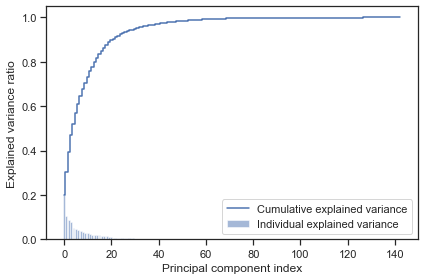

In [38]:
pca_ida = PCA()
pca_ida_fit = pca_ida.fit_transform(df_tmp)
explained_variance_ida = pca_ida.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(explained_variance_ida)
plt.bar(range(0,len(explained_variance_ida)), explained_variance_ida, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


As seen in the chart, selecting the first 15 components explains 70% variance in the data. Addition of more than 15 components doesn't add much variance.

In [39]:
pca_ida = PCA(n_components=15)
pca_ida_fit = pca_ida.fit_transform(df_tmp)
explained_variance_ida = pca_ida.explained_variance_ratio_

sum(explained_variance_ida)

0.8158240631724488

In [40]:
cols = []
for i in range(pca_ida_fit.shape[1]):
    cols.append('ida_reason_code_pca_'+str(i+1))
tmp = pd.DataFrame(pca_ida_fit, columns=cols)
df = pd.concat([df,tmp], axis=1)

#### Socure Codes Analysis

There are 4 types of reason codes. These features appear with list of codes for every application. They are:

    - socure_phonerisk_reason_code
    - socure_addressrisk_reason_code
    - socure_emailrisk_reason_code
    - socure_reason_code

In [41]:
# Cleaning the list of reason codes
def clean_string(x):
    if x != None:
        x = [val.strip("""'|[| |"|,|]""") for val in x.split('\n') if not val.strip("""'|[| |"|,|]""") in ['',None]]
    return x

socure_cols = ['socure_phonerisk_reason_code','socure_addressrisk_reason_code','socure_emailrisk_reason_code'
              ,'socure_reason_code']
df_socure = df[['application_id','ns_flag'] + socure_cols]

# Collecting the cleaned reason codes
for col in socure_cols:
    df_socure[col] = df_socure[col].str.lower()
    df_socure[col] = df_socure[col].apply(clean_string)

In [42]:
socure_cols = ['socure_phonerisk_reason_code','socure_addressrisk_reason_code','socure_emailrisk_reason_code'
              ,'socure_reason_code']
dict_cols = {}
for col in socure_cols:
    df_socure = df_socure.drop(col, 1).join(df_socure[col].str.join('|').str.get_dummies())
    socure_cols = df_socure.columns[df_socure.columns.str.startswith('socure')].to_list()
    true_cols = list(set(df_socure.columns.to_list()) - set(socure_cols) - set(['application_id','ns_flag']))
    new_cols = []
    for col2 in true_cols:
        new_cols.append(col+'_'+col2)
    dict_cols = dict(zip(true_cols, new_cols)) | dict_cols
    df_socure.rename(columns=dict_cols, inplace=True)

df_socure = df_socure.T
df_socure = df_socure[~df_socure.index.duplicated(keep='first')].T

In [43]:
df_socure = df_socure.convert_dtypes()

In [44]:
pd.DataFrame(list(set(df_socure.columns) - set(['application_id','ns_flag'])
                 ), columns=['feature']).to_pickle(project_path+'models/socure_reason_codes_columns.pkl')


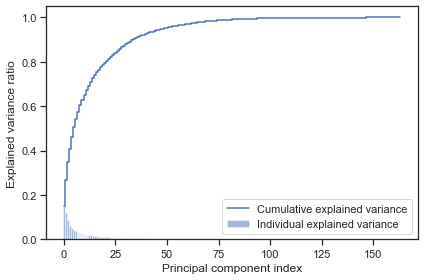

In [45]:
pca_socure = PCA()
pca_socure_fit = pca_socure.fit_transform(df_socure.drop(columns=['application_id','ns_flag']))
explained_variance_socure = pca_socure.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(explained_variance_socure)
plt.bar(range(0,len(explained_variance_socure)), explained_variance_socure, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


As seen in the chart, selecting the first 20 components explains 80% variance in the data. Addition of more than 20 components doesn't add much variance.

In [46]:
pca_socure = PCA(n_components=20)
pca_socure_fit = pca_socure.fit_transform(df_socure.drop(columns=['application_id','ns_flag']))
explained_variance_socure = pca_socure.explained_variance_ratio_

sum(explained_variance_socure)

0.7853357798718014

In [47]:
cols = []
for i in range(pca_socure_fit.shape[1]):
    cols.append('socure_reason_code_pca_'+str(i+1))
tmp = pd.DataFrame(pca_socure_fit, columns=cols)

df = pd.concat([df,tmp], axis=1)

In [48]:
df.shape

(87292, 61)

In [49]:
# Removing reason code features as these are already encoded
df.drop(columns=ida_reason_cols+socure_reason_cols, inplace=True)

In [50]:
df.shape

(87292, 54)